In [1]:
import pandas as pd
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
reviews['num_letters'] = reviews.review_comment_message.str.count('[a-zA-Z]')
reviews = reviews[reviews.num_letters > 0]  # Filter valid comments
reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,num_letters
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,31.0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,82.0
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,139.0


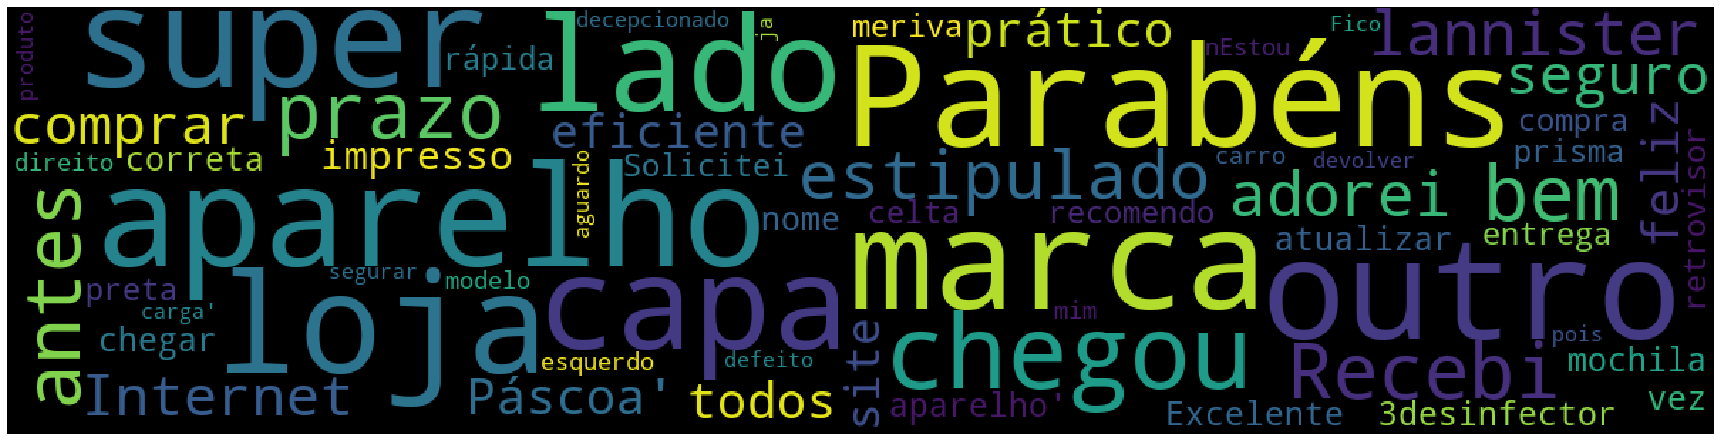

In [4]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words = stopwords.words('portuguese')
comments = reviews.review_comment_message.values
wordcloud = WordCloud(background_color='black',
                     stopwords=stop_words,
                     max_words=200,
                     max_font_size=100,
                     random_state=520,
                     width=1200,
                     height=300,
                     mask=None)
wordcloud.generate(str(comments))
plt.figure(figsize=(24,16))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()

In [5]:
# NLP
import nltk 
import numpy as np
import seaborn as sns

In [6]:
from googletrans import Translator
translator = Translator()
def translation_pt(text):
    translations = translator.translate(list(text))
    translation_text = pd.Series(translation.text for translation in translations).values
    return translation_text


In [7]:
from nltk import FreqDist
def freq_words(x,terms = 20):
    all_words = ' '.join(text for text in x)
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})
    d = words_df.nlargest(columns='count',n=terms)
#     translator = Translator()
#     translations = translator.translate(list(d.word))
#     d['word'] = pd.Series(translation.text for translation in translations).values
    d['word'] = translation_pt(d.word)
    plt.figure(figsize=(60,30))
    ax = sns.barplot(data=d,x='word',y='count')
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.xlabel('word',fontsize=40)
    plt.ylabel('count',fontsize=40)
    plt.show()

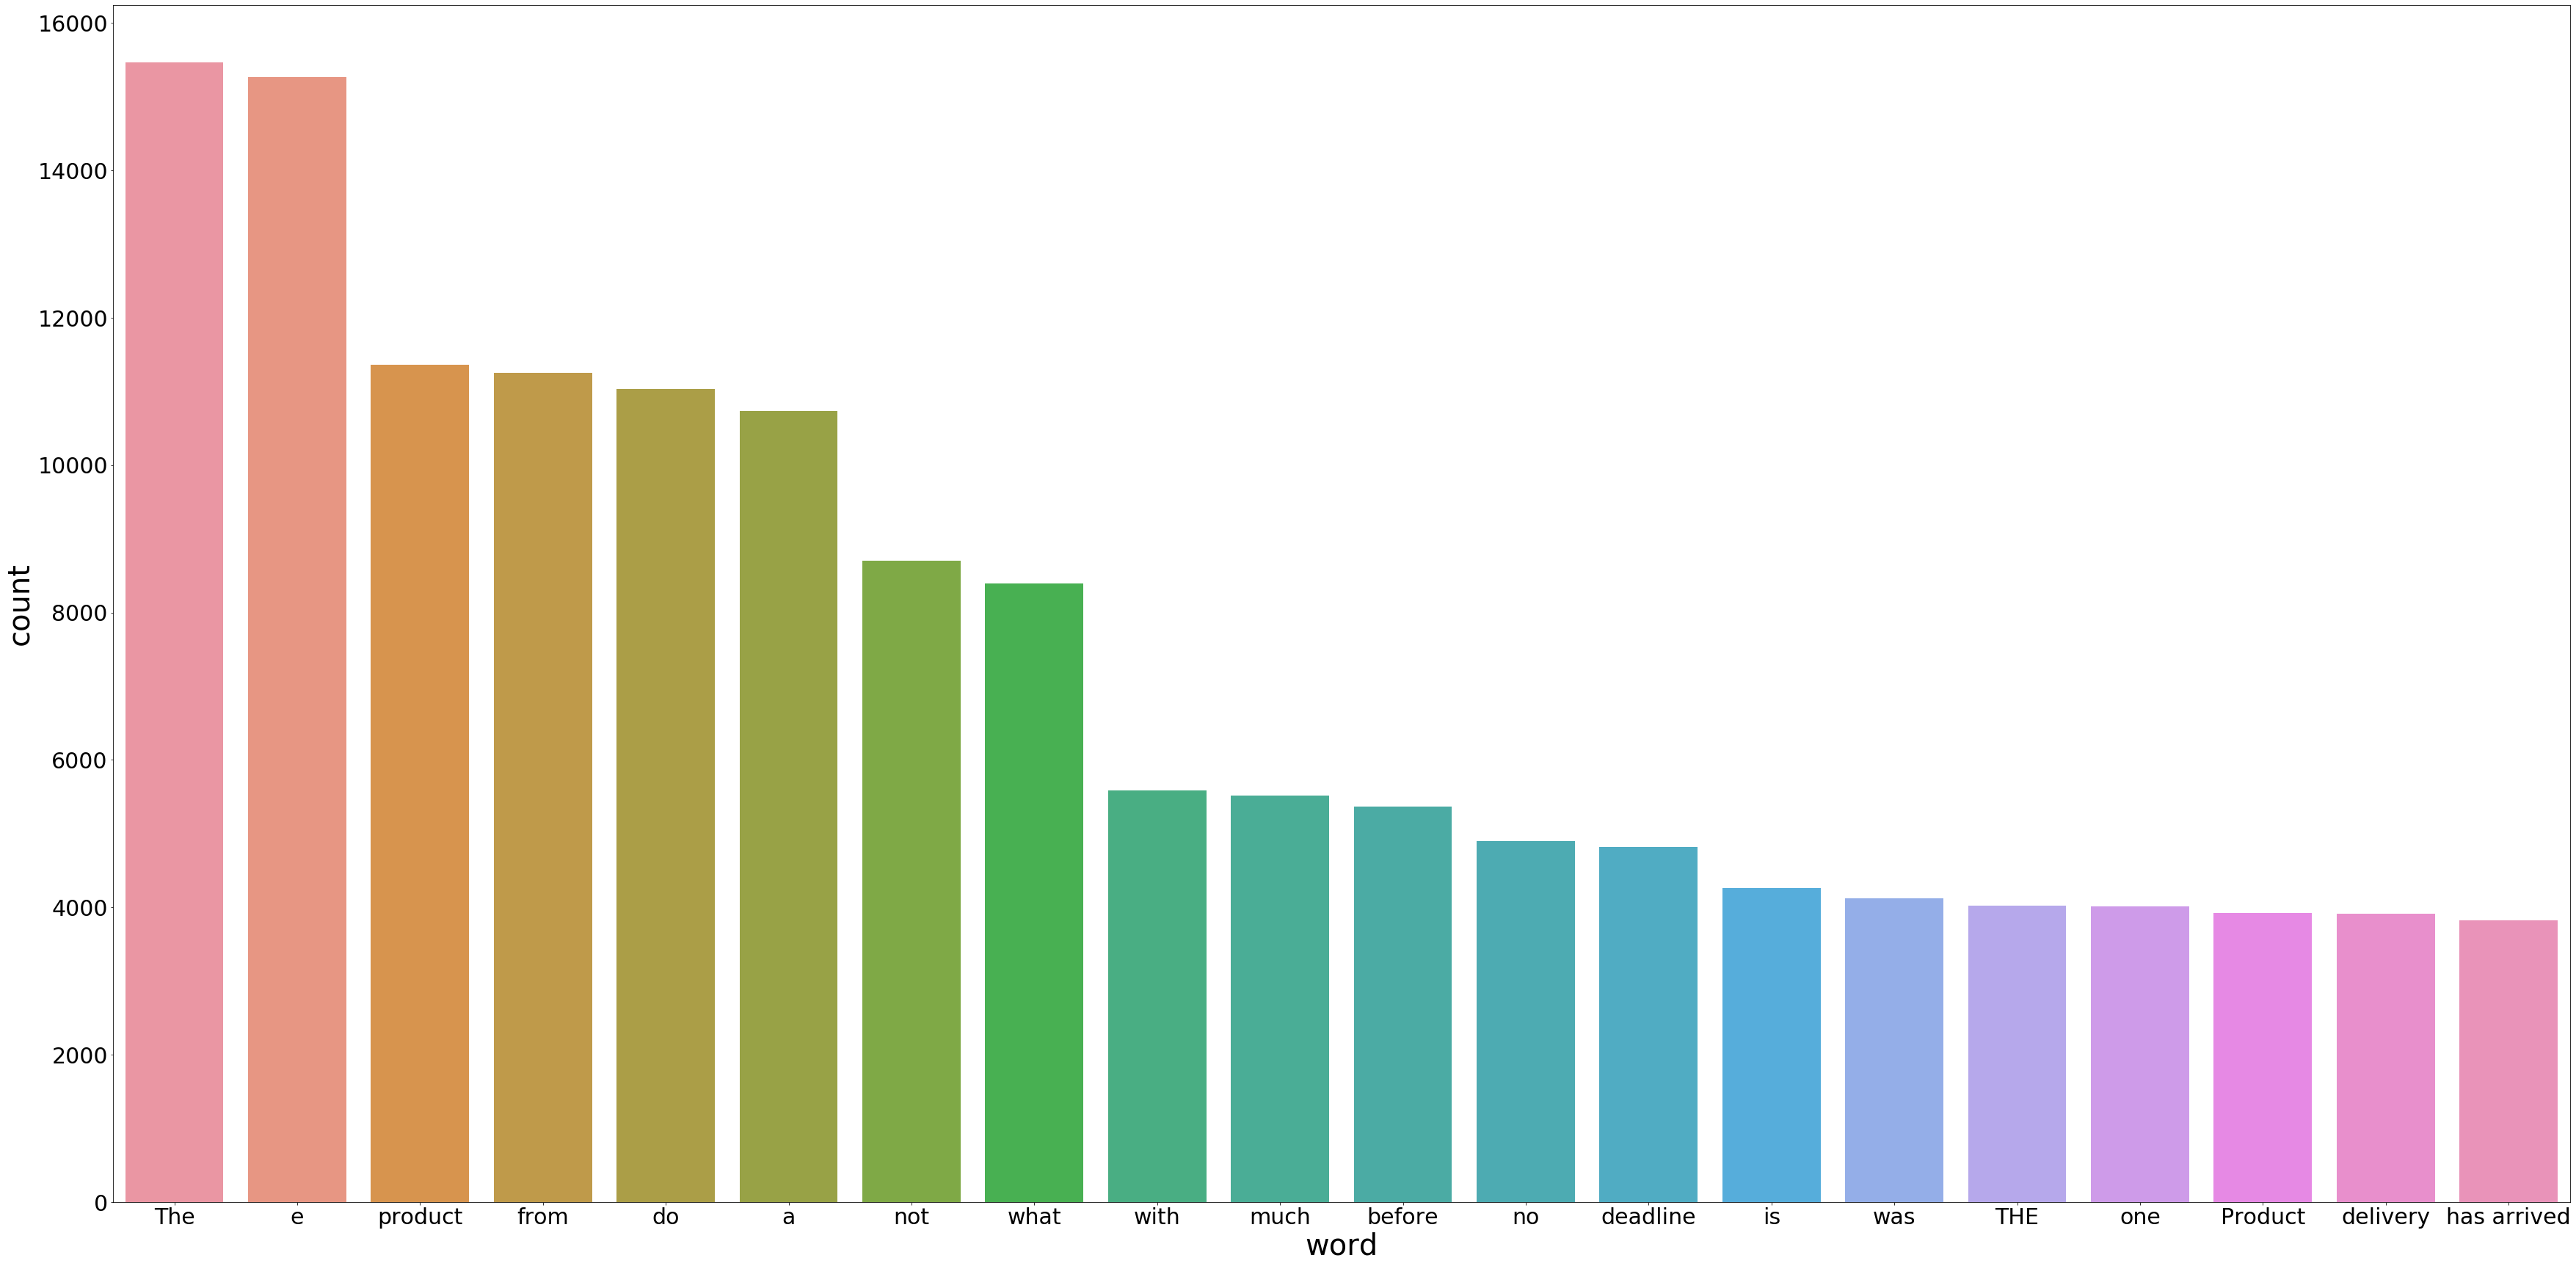

In [8]:
freq_words(reviews.review_comment_message)

In [9]:
# function to remove stopwords
def remove_stopwords(rev):
    stop_words.extend(['é', 'ok', 'ta', 'tá', 'att', 'att.', 'sr', 'porém','produto', 'recomendo'])
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [ ]:
# remove unwanted characters, numbers and symbols
reviews['review_comment_message'] = reviews['review_comment_message'].str.replace("[^a-zA-Z#]"," ")
# remove short words(length<3)
reviews['review_comment_message'] = reviews['review_comment_message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# remove stopwords from the text
reviews_data = [remove_stopwords(r.split()) for r in reviews.review_comment_message]
# make entire text lowercase
reviews_data = [r.lower() for r in reviews_data]



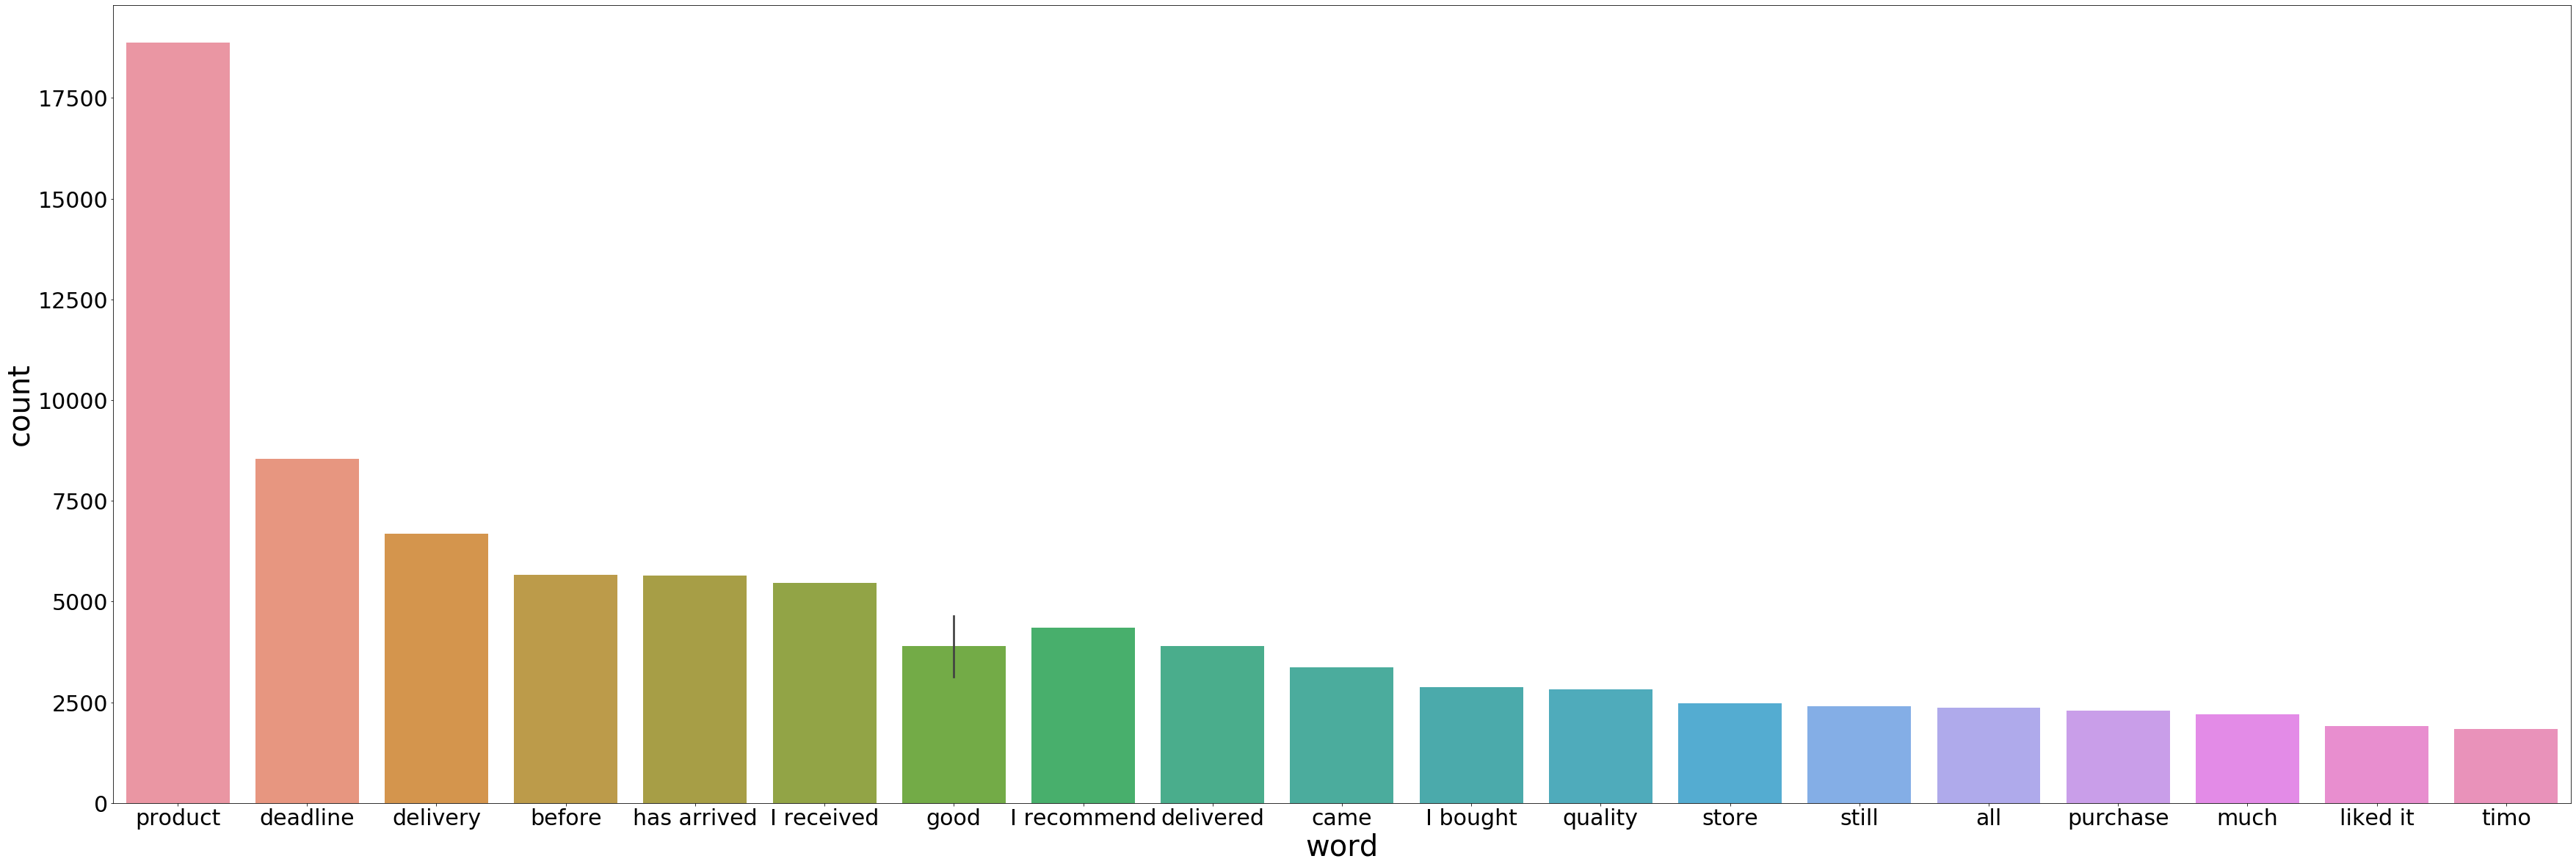

In [9]:
freq_words(reviews_data)

In [10]:
import spacy
nlp = spacy.load("pt_core_news_sm",disable=['parser','ner'])
def lemmatization(texts,tags=['NOUN','ADJ']):
    output = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [11]:
tokenized_reviews = pd.Series(reviews_data).apply(lambda x: x.split())
print(tokenized_reviews[1])

['parab', 'lojas', 'lannister', 'adorei', 'comprar', 'internet', 'seguro', 'tico', 'parab', 'todos', 'feliz', 'scoa']


In [12]:
reviews_data2 = lemmatization(tokenized_reviews)
print(reviews_data2[1])


['segurar', 'tico', 'feliz']


In [13]:
print(reviews_data2[15])


['bom']


In [14]:
reviews_data3 = []
for i in range(len(reviews_data2)):
    reviews_data3.append(' '.join(reviews_data2[i]))
reviews.review_comment_message = reviews_data3

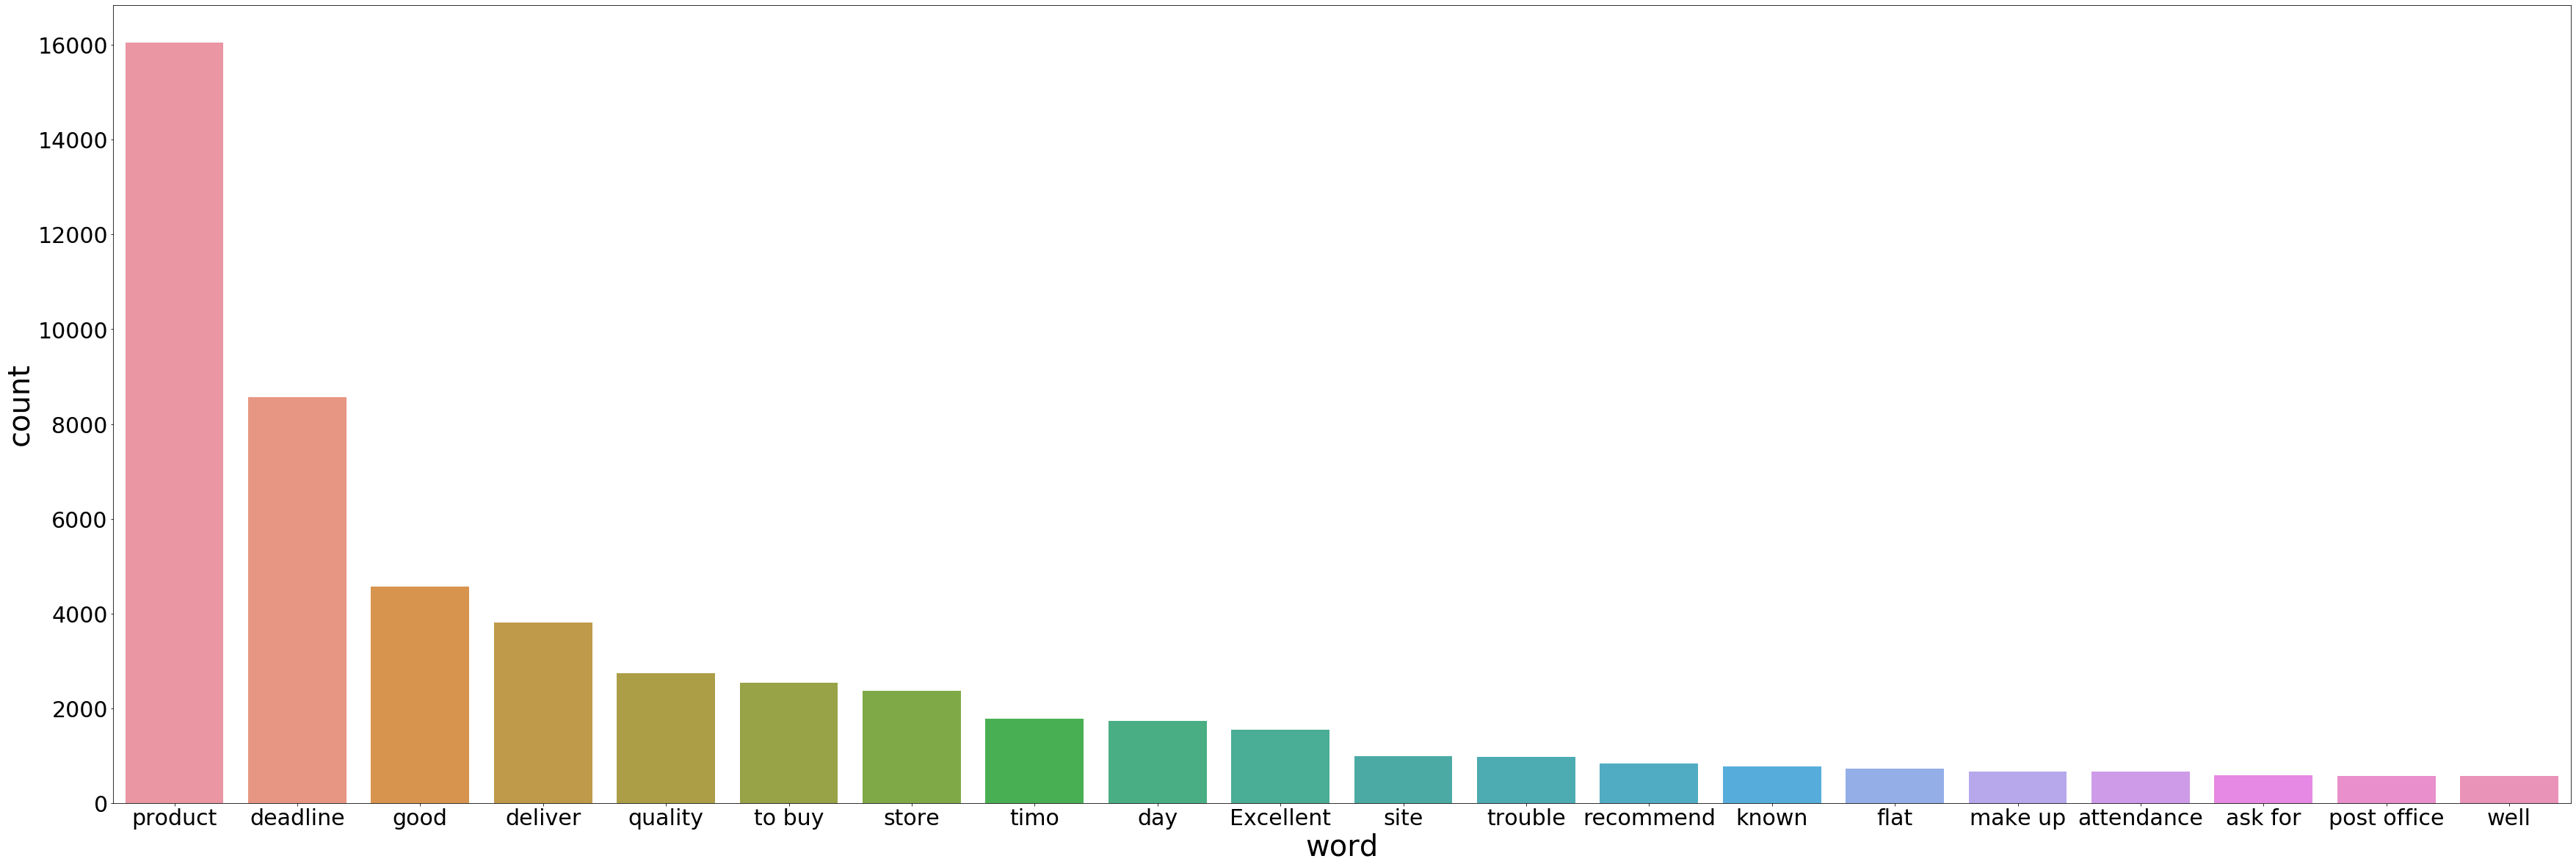

In [15]:
freq_words(reviews.review_comment_message)

# Building an LDA model

In [16]:
import gensim
from gensim import corpora

In [17]:
dictionary = corpora.Dictionary(reviews_data2)

In [18]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_data2]

In [19]:
LDA = gensim.models.ldamodel.LdaModel

In [68]:
lda_model = LDA(corpus=doc_term_matrix,
               id2word=dictionary,
               num_topics=4,
               random_state=1,
               chunksize=1000,
               passes=50)

In [69]:
lda_model.show_topics()

[(0,
  '0.162*"prazo" + 0.091*"bom" + 0.069*"dia" + 0.026*"atendimento" + 0.022*"pedir" + 0.021*"contato" + 0.019*"vel" + 0.018*"empresar" + 0.015*"datar" + 0.014*"respostar"'),
 (1,
  '0.040*"recomendar" + 0.035*"perfazer" + 0.021*"material" + 0.020*"embalagem" + 0.020*"cor" + 0.020*"satisfeito" + 0.019*"foto" + 0.019*"nao" + 0.018*"dinheiro" + 0.017*"melhor"'),
 (2,
  '0.092*"comprar" + 0.087*"loja" + 0.068*"entregar" + 0.039*"problema" + 0.028*"noto" + 0.023*"site" + 0.021*"correio" + 0.018*"momento" + 0.017*"certar" + 0.017*"corretar"'),
 (3,
  '0.372*"produto" + 0.104*"prazo" + 0.062*"qualidade" + 0.051*"bom" + 0.045*"entregar" + 0.042*"timo" + 0.036*"excelente" + 0.013*"satisfazer" + 0.013*"diferente" + 0.012*"vendedor"')]

In [70]:
keys0 = [lda_model.get_topic_terms(0)[i][0] for i in range(10)]
topic0 = [lda_model.id2word[key] for key in keys0]
topic_trans0 = translation_pt(topic0)
topic_trans0

array(['deadline', 'good', 'day', 'attendance', 'ask for', 'contact',
       'well', 'empresar', 'flat', 'answered'], dtype=object)

In [71]:
keys1 = [lda_model.get_topic_terms(1)[i][0] for i in range(10)]
topic1 = [lda_model.id2word[key] for key in keys1]
topic_trans1 = translation_pt(topic1)
topic_trans1

array(['recommend', 'make up', 'material', 'packing', 'cor', 'pleased',
       'photo', 'not', 'money', 'best'], dtype=object)

In [72]:
keys2 = [lda_model.get_topic_terms(2)[i][0] for i in range(10)]
topic2 = [lda_model.id2word[key] for key in keys2]
topic_trans2 = translation_pt(topic2)
topic_trans2

array(['to buy', 'store', 'deliver', 'trouble', 'known', 'site',
       'post office', 'moment', 'fight', 'corretar'], dtype=object)

In [73]:
keys3 = [lda_model.get_topic_terms(3)[i][0] for i in range(10)]
topic3 = [lda_model.id2word[key] for key in keys3]
topic_trans3 = translation_pt(topic3)
topic_trans3

array(['product', 'deadline', 'quality', 'good', 'deliver', 'timo',
       'Excellent', 'to satisfy', 'different', 'salesman'], dtype=object)

In [27]:
import pyLDAvis
import pyLDAvis.gensim
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.311334  0.036045       1        1  36.108269
1      0.122752 -0.273726       2        1  32.870594
0      0.188582  0.237681       3        1  31.021135, topic_info=    Category         Freq       Term         Total  loglift  logprob
0    Default  8288.000000      prazo   8288.000000  30.0000  30.0000
10   Default  4380.000000        bom   4380.000000  29.0000  29.0000
18   Default  3661.000000   entregar   3661.000000  28.0000  28.0000
62   Default  2586.000000  qualidade   2586.000000  27.0000  27.0000
15   Default  2404.000000    comprar   2404.000000  26.0000  26.0000
..       ...          ...        ...           ...      ...      ...
284   Topic3   199.132187     fretar    200.043945   1.1659  -5.1668
272   Topic3   153.988876    cadeira    154.730469   1.1657  -5.4239
526   Topic3   140.547577      ssimo    141.262192   1.1654  -5.5153
12    Topic3  4969.469727    produto  15477.274414   0.0344  -1.9497
16    Topic3   693.730469       loja   2262.271240  -0.0115  -3.9187

[131 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
183       2  0.996871  acabamento
74        2  0.998949     acordar
221       1  0.004951    aguardar
221       3  0.995088    aguardar
201       1  0.995515        atar
...     ...       ...         ...
98        3  0.997753         vcs
13        3  0.997757         vel
14        3  0.998060    vendedor
238       1  0.999196         vez
207       1  0.994981       vezar

[104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])